In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import koreanize_matplotlib
import seaborn as sns
from scipy import stats

import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, StandardScaler
import shap

import warnings

In [34]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print(rmsle_val)
    print(rmse_val)
    print(mae_val)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [35]:
warnings.filterwarnings('ignore')
# 노트북 안에 그래프를 그리기 위해
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
mpl.rcParams['axes.unicode_minus'] = False # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처

RANDOM_STATE = 110
pd.set_option('display.max_columns', None)

train_df = pd.read_csv("../../data/bike/train.csv", parse_dates=['datetime'])
test_df = pd.read_csv("../../data/bike/test.csv", parse_dates=['datetime'])
santander_submission_df = pd.read_csv("../../data/bike/sampleSubmission.csv")

> - 2011년 1월 ~ 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안 자전거 대여 횟수 데이터가 있다.

> - datetime: hourly date + timestamp
> - season: 1 - 봄, 2 - 여름, 3- 가을, 4 - 겨울
> - holyday: 1 - 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 - 휴일이 아닌 날
> - workingday: 1 - 토, 일요일의 주말 및 휴일이 아닌 주중, 0 - 주말 및 휴일
> - weather:
> - - 1 = 맑음, 약간 구름 낀 흐림 / 2 = 안개, 안개 + 흐림 / 3 = 가벼운 눈, 가벼운 비 + 천둥 / 4 = 심한 눈/비, 천둥/번개
> - temp: 온도(섭씨)
> - atemp: 체감 온도(섭씨)
> - humidity: 상대 습도
> - windspeed: 풍속
> - casual: 사전에 등록되지 않은 사용자가 대여한 횟수
> - registered: 사전에 등록된 사용자가 대여한 횟수
> - count: 대여 횟수

In [36]:
train_df.shape

(10886, 12)

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [38]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [39]:
train_df.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [40]:
train_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<Axes: >

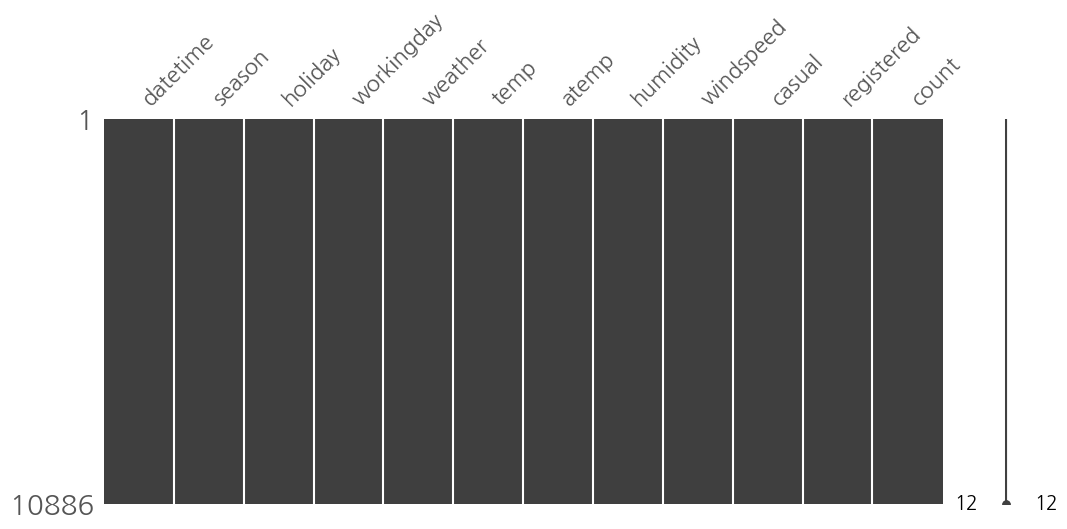

In [41]:
import missingno as msno

msno.matrix(train_df, figsize=(12,5))

In [42]:
train_df['year'] = train_df.datetime.apply(lambda x: x.year)
train_df['month'] = train_df.datetime.apply(lambda x: x.month)
train_df['day'] = train_df.datetime.apply(lambda x: x.day)
train_df['hour'] = train_df.datetime.apply(lambda x: x.hour)

# train_df.drop(['datetime'], axis=1, inplace=True)

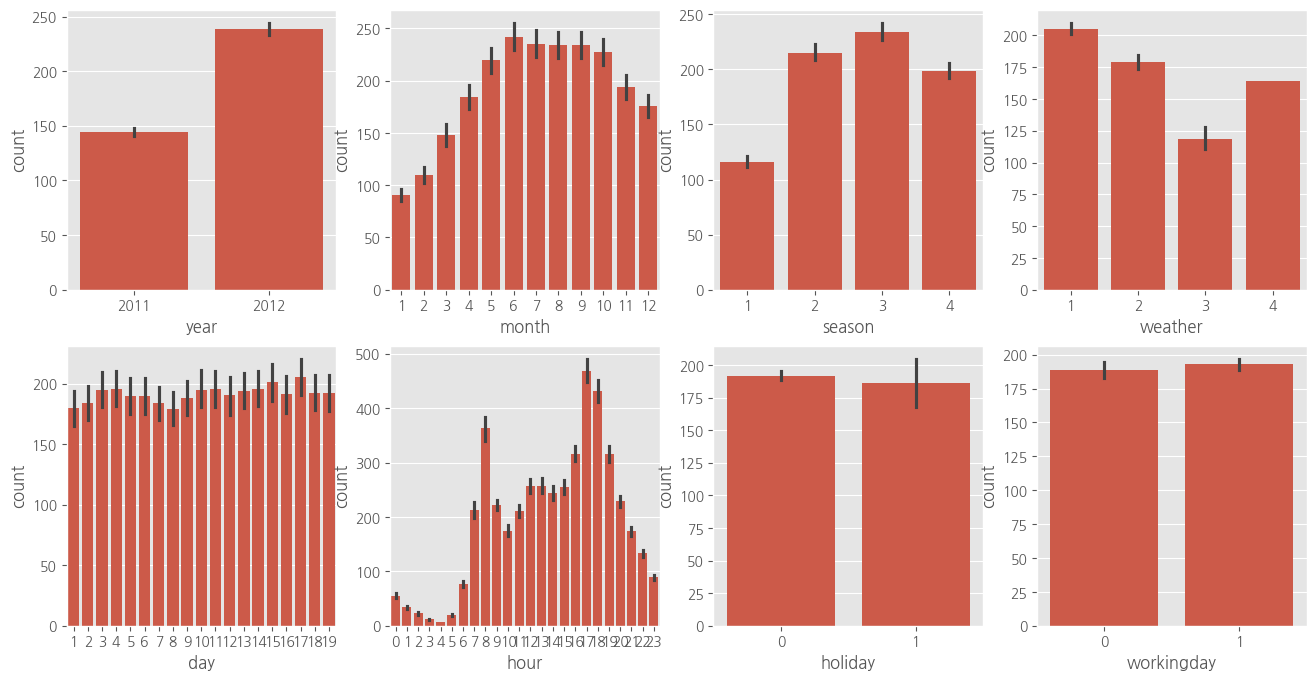

In [43]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']

for i, feature in enumerate(features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data=train_df, ax=axs[row][col])

> - 연도별 대여량은 2011년 보다 2012년이 더 많다.
> - 월 별 대여량은 6월에 가장 많고 7~10월도 대여량이 많다. 그리고 1월에 가장 적다.
> - 일 별 대여량은 1일부터 19일까지만 있고 나머지 날짜는 test.csv에 있다. 그래서 이 데이터는 피처로 사용하면 안 된다.
> - 시간 대 대여량을 보면 출퇴근 시간에 대여량이 많은 것 같다. 하지만 주말과 나누어 볼 필요가 있을 것 같다.
> - 분, 초도 다 0이기 때문에 의미가 없다. -> 생략

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

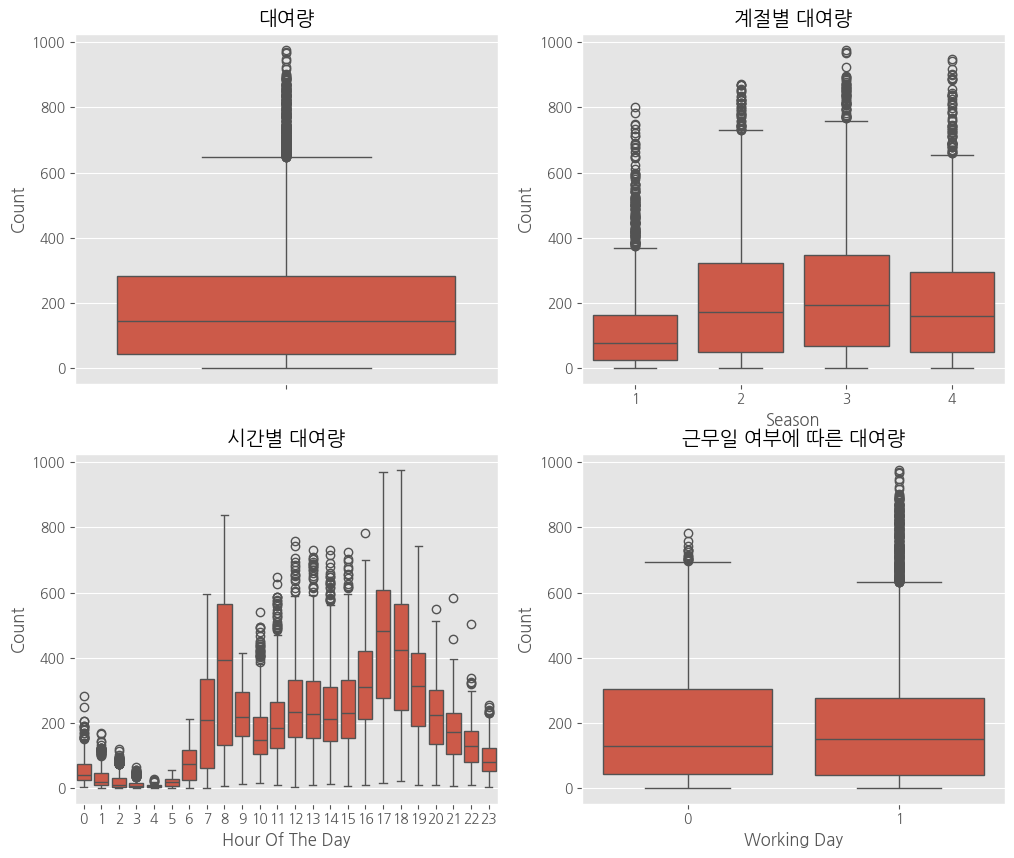

In [44]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train_df,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train_df,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train_df,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train_df,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

### dt.dayofweek
> - datetime 열에 있는 날짜 정보를 사용하여 요일을 새로운 열 dayofweek에 추가하는 코드
> - train_df["datetime"] 열에서 날짜 정보를 기반으로 요일을 숫자로 변환하여 새로운 열 dayofweek에 저장

> - 0: 월요일 (Monday)
> - 1: 화요일 (Tuesday)
> - 2: 수요일 (Wednesday)
> - 3: 목요일 (Thursday)
> - 4: 금요일 (Friday)
> - 5: 토요일 (Saturday)
> - 6: 일요일 (Sunday)

In [46]:
train_df["dayofweek"] = train_df["datetime"].dt.dayofweek
train_df.shape

(10886, 17)

In [48]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [50]:
train_df["dayofweek"].value_counts()

dayofweek
5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: count, dtype: int64

<Axes: xlabel='hour', ylabel='count'>

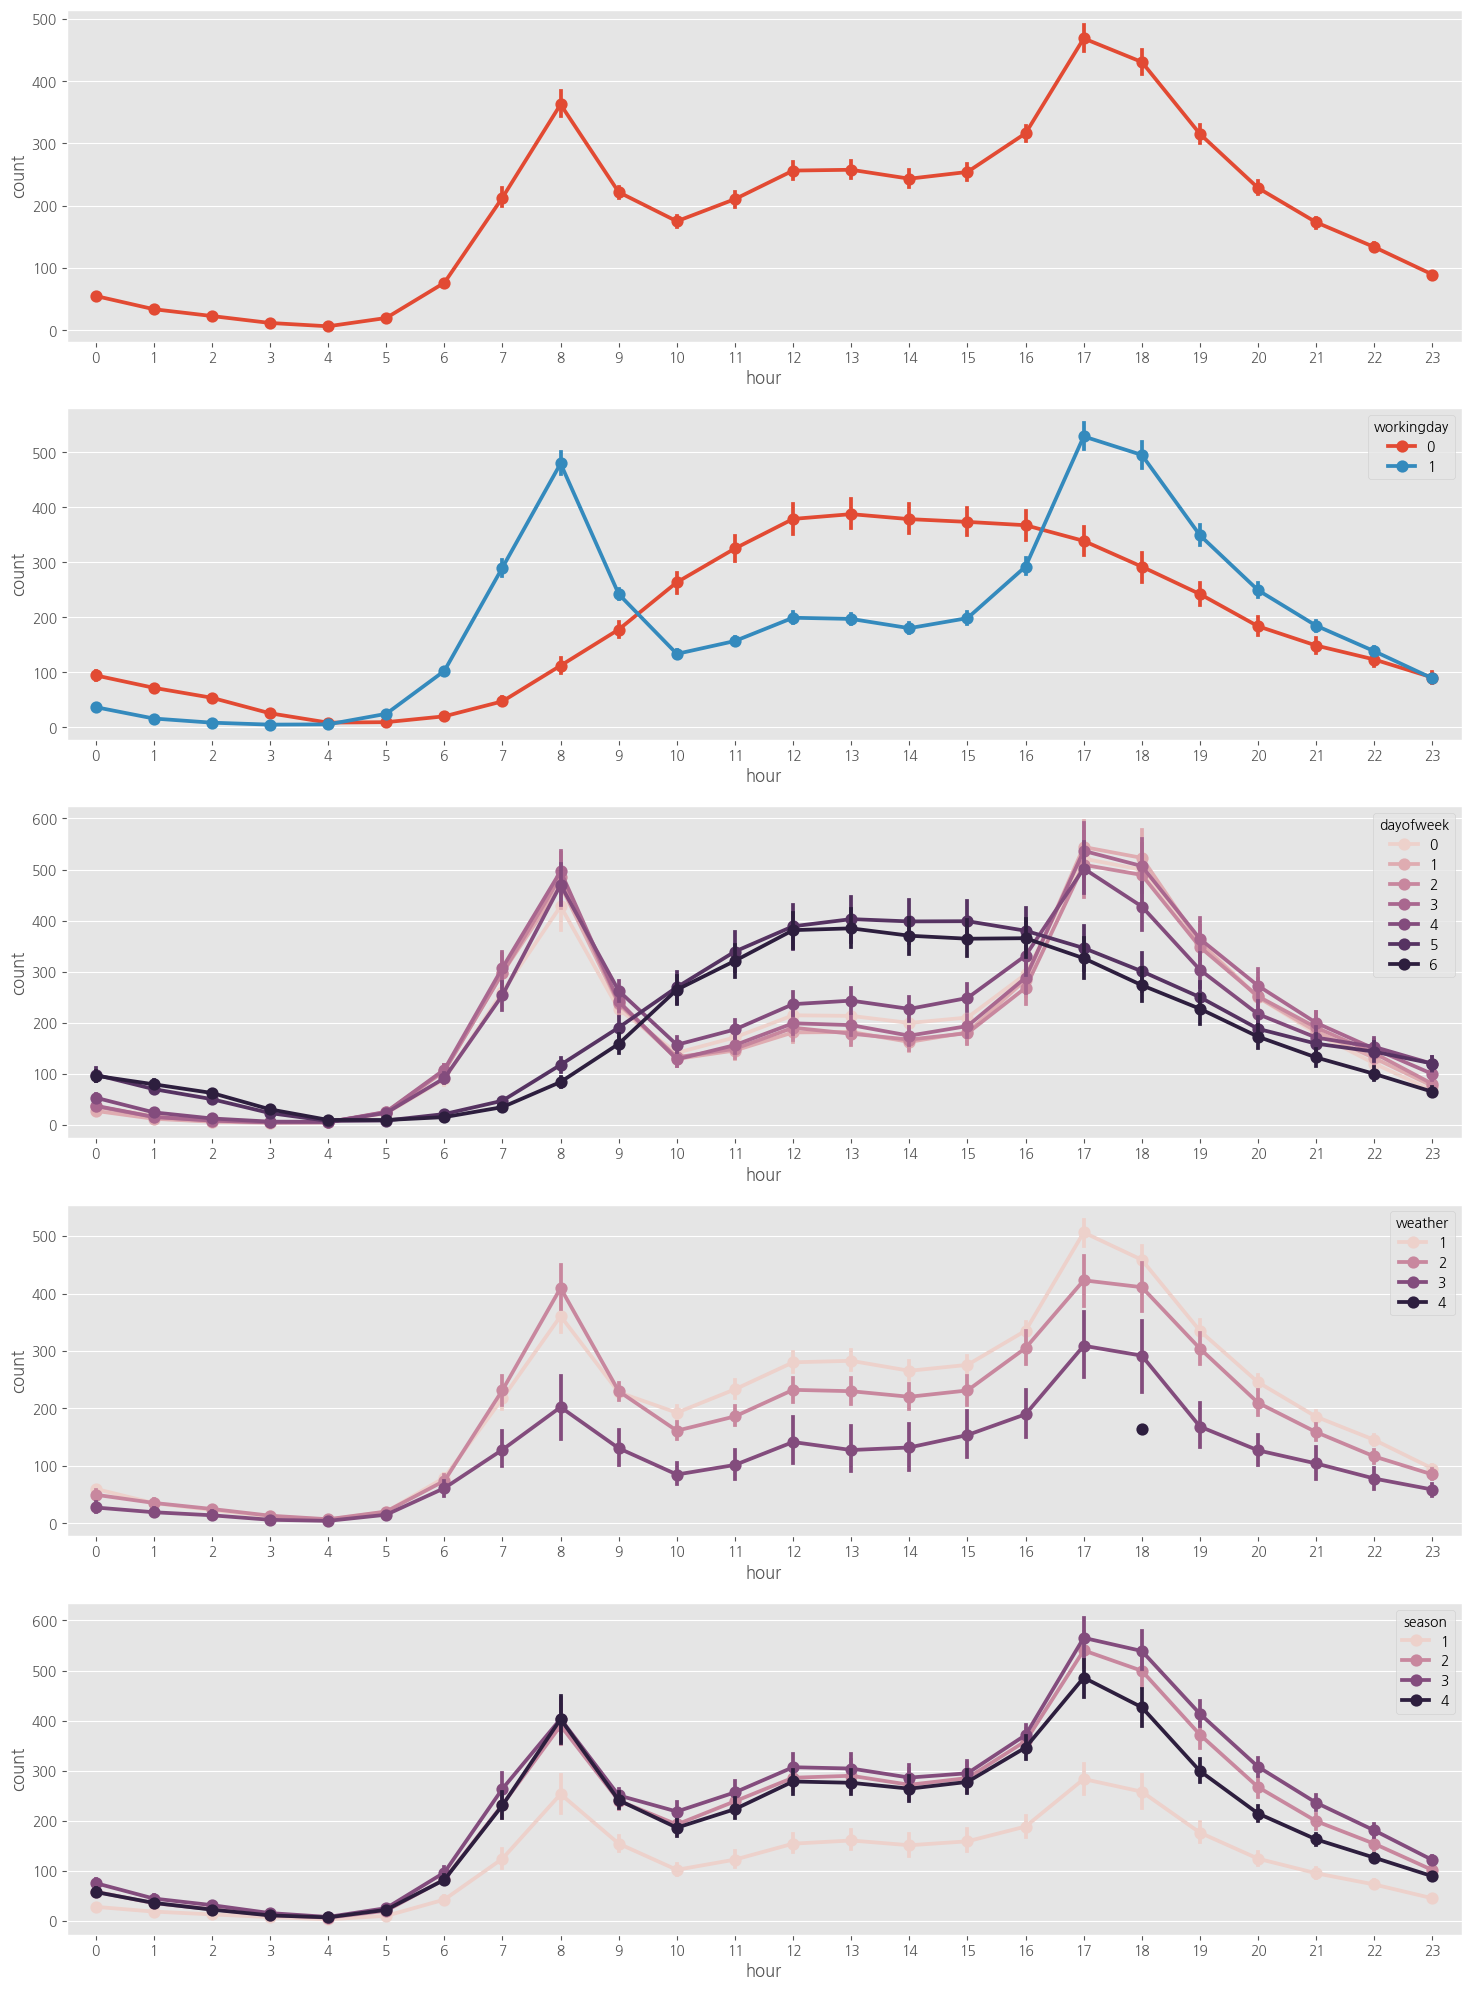

In [51]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train_df, x="hour", y="count", ax=ax1)

sns.pointplot(data=train_df, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train_df, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train_df, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train_df, x="hour", y="count", hue="season", ax=ax5)

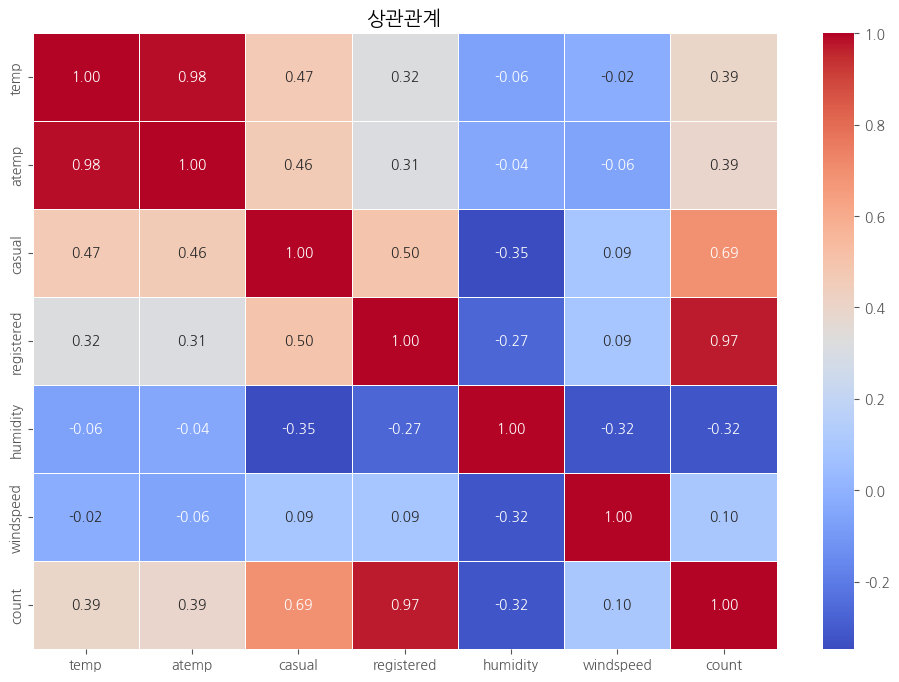

In [56]:
corr_matrix = train_df[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()

# 히트맵으로 상관관계 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# 그래프 타이틀 추가
plt.title('상관관계')

# 그래프 출력
plt.show()

> - 온도, 습도, 풍속은 거의 연관관계가 없다.
> - 대여량과 가장 연관이 높은 건 registered 로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다.
> - atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.

<Axes: xlabel='humidity', ylabel='count'>

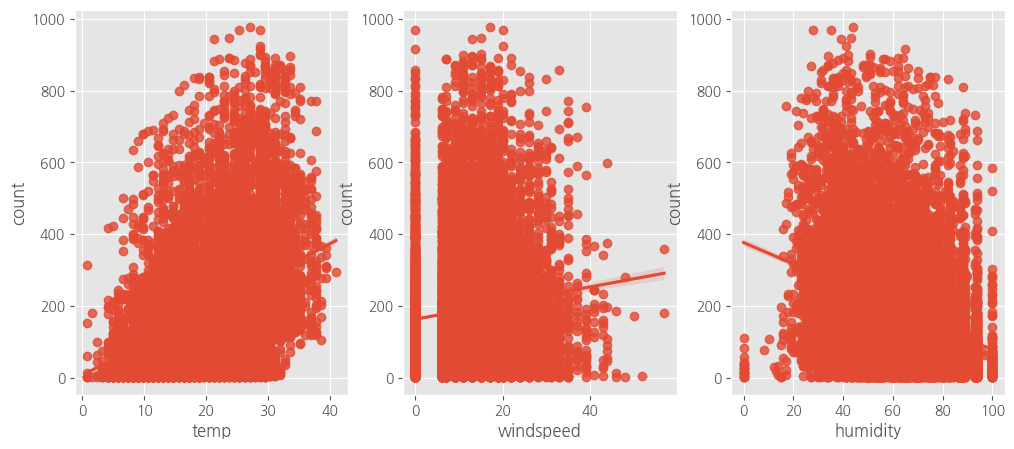

In [59]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train_df,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train_df,ax=ax2)
sns.regplot(x="humidity", y="count", data=train_df,ax=ax3)

풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해 본다.

In [60]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train_df["year_month"] = train_df["datetime"].apply(concatenate_year_month)

print(train_df.shape)
train_df[["datetime", "year_month"]].head()

(10886, 18)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<Axes: xlabel='year_month', ylabel='count'>

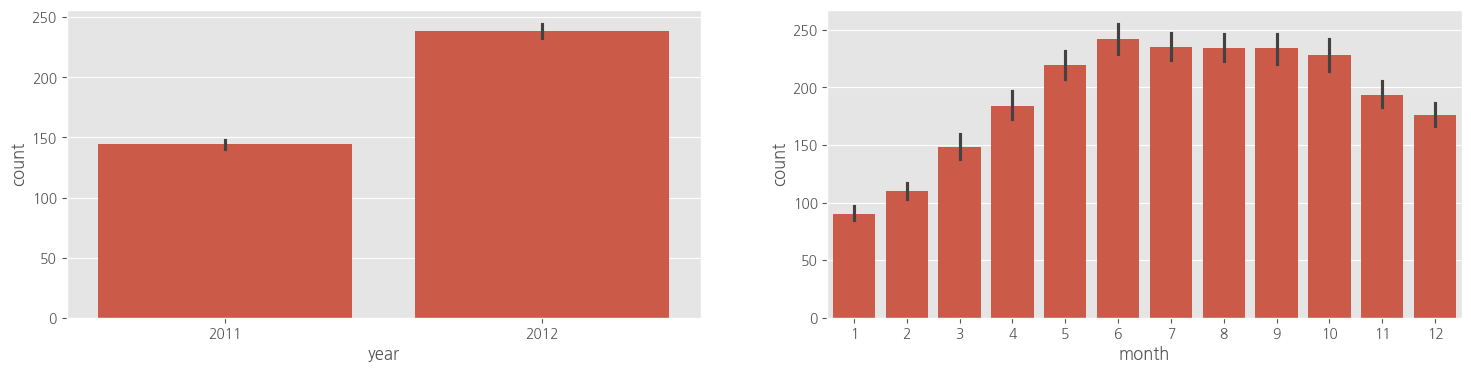

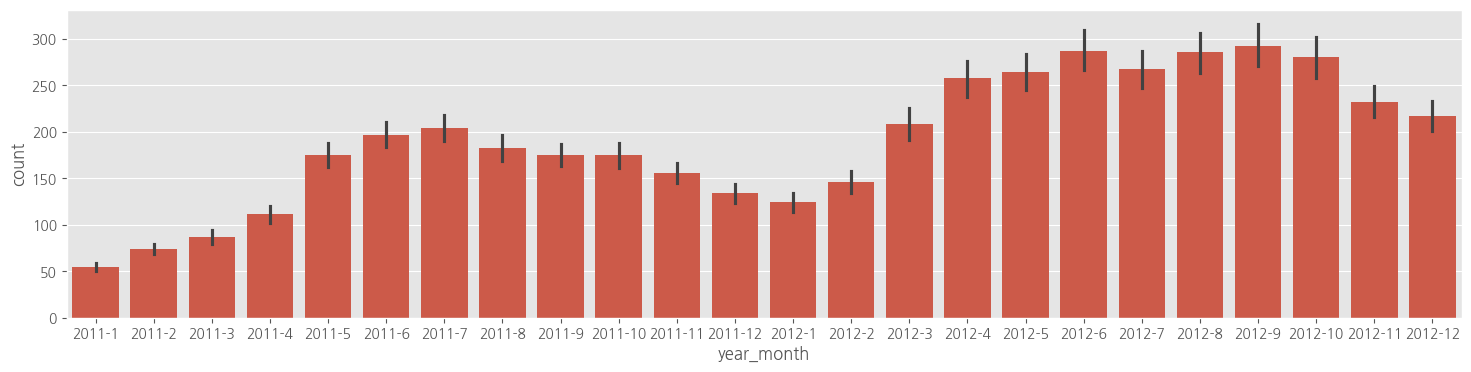

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train_df, x="year", y="count", ax=ax1)
sns.barplot(data=train_df, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train_df, x="year_month", y="count", ax=ax3)

> - 2011년보다 2012년의 대여량이 더 많다.
> - 겨울보다는 여름에 대여량이 많다.
> - 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세이다.

### train_df에서 count 열의 이상치를 제거한 새로운 데이터프레임 trainWithoutOutliers를 생성하는 코드
> - 표준 편차를 이용하여 count 값이 평균에서 크게 벗어난 값(이상치)을 제거

> - 각 count 값에서 평균을 뺀 후 절대값을 취한다. 이렇게 하면 각 데이터가 평균으로부터 얼마나 떨어져 있는지를 알 수 있다. 음수는 제거되고 모두 양수로 변환.
> - count 열의 표준 편차에 3을 곱한다. 통계적으로, 정규분포에서는 약 99.7%의 데이터가 평균으로부터 3 표준 편차 이내에 위치. 즉, 이 범위를 벗어나는 값들은 이상치일 가능성이 크다.

In [63]:
# trainWithoutOutliers
trainWithoutOutliers = train_df[np.abs(train_df["count"] - train_df["count"].mean()) <= (3*train_df["count"].std())]

print(train_df.shape)
print(trainWithoutOutliers.shape)

(10886, 18)
(10739, 18)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229772, 4.562423868087808, 0.958117678090961))

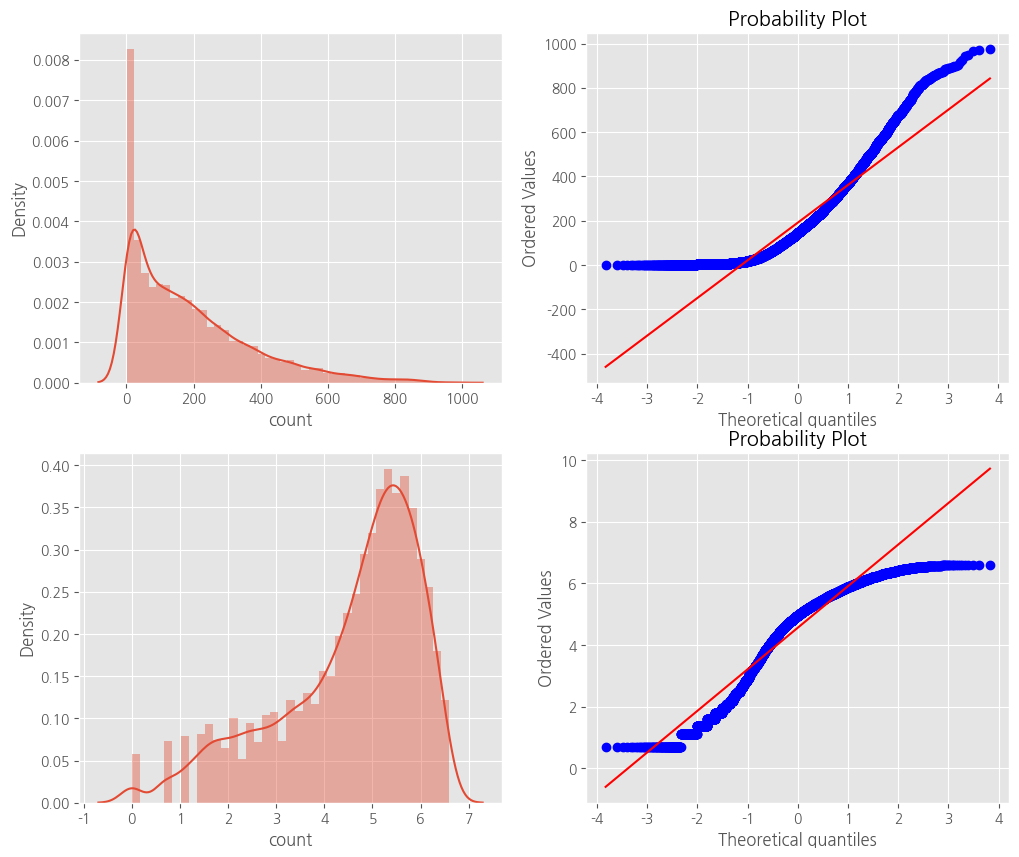

In [64]:
# count값의 데이터 분포도를 파악
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train_df["count"], ax=axes[0][0])
stats.probplot(train_df["count"], dist='norm', fit=True, plot=axes[0][1])

sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.